In [3]:
import geopandas as gpd
import pandas as pd
from glob import glob
import os
import re
import cityImage as ci

import numpy as np
import itertools
# import pingouin as pin

In [4]:
## Directories etc.
epsg = 3003 # Italy crs
crs = 'EPSG:'+str(epsg)

input_folder = "input/"
input_volumes = input_folder+"streetVolumes/"
input_routes = input_folder+"routes/"
place_name = 'TorinoCentre'

## Importing Files
### Importing Volumes

In [3]:
# import os

# # Function to transform the 10th character
# def transform_char(c):
#     if c.isdigit():
#         # If the character is between '0' and '2', change it
#         if c == '6':
#             return '3'
#         # elif c == '1':
#         #     return '5'
#         # elif c == '2':
#         #     return '6'
#         # # Keep other characters unchanged
#         return c
#     return c

# # Function to rename the files
# def rename_files_in_directory(directory):
#     # Get all files in the specified directory
#     files = os.listdir(directory)

#     for filename in files:
#         # Ensure the filename has at least 10 characters
#         if len(filename) > 9:
#             # Convert the filename to a list of characters (to modify specific positions)
#             new_filename = list(filename)

#             # Transform the 10th character (index 9)
#             new_filename[9] = transform_char(new_filename[9])

#             # Join the list of characters back into a string
#             new_filename = ''.join(new_filename)

#             # Only rename if the filename has changed
#             if new_filename != filename:
#                 try:
#                     # Full paths for the old and new filenames
#                     old_path = os.path.join(directory, filename)
#                     new_path = os.path.join(directory, new_filename)

#                     # Rename the file
#                     os.rename(old_path, new_path)
#                     print(f"Renamed: {filename} -> {new_filename}")
#                 except Exception as e:
#                     print(f"Error renaming {filename}: {e}")
#         else:
#             print(f"Skipping {filename}, it's too short.")

# # Specify the directory where your files are located
# directory_path = 'C:\\Users\\gfilo\\OneDrive - The University of Liverpool\\Output\\routes'

# rename_files_in_directory(directory_path)

In [5]:
## street segments layer
edges_gdf = gpd.read_file(input_folder+place_name+"_edges.gpkg")
edges_gdf.index = edges_gdf.edgeID
edges_gdf.index.name = None
edges_gdf.index = edges_gdf.index.astype(int)
edges_gdf['length'] = edges_gdf.geometry.length

In [7]:
# Define the number of jobs and days

dfs = []
# Match all files in the directory with the pattern 'yyyyMMdd_*.csv'
csv_files = [os.path.basename(file) for file in glob(os.path.join(input_volumes, '*_*.csv'))]

# Iterate through each file
for file in csv_files:
    # Extract job and day from the filename (e.g., '20250410_0_1.csv' -> job=0, day=1)
    parts = file.split('_')
    job = int(parts[1])  # Extract job (index 1)
    day = int(parts[2].split('.')[0])  # Extract day (index 2, removing '.csv')

    try:
        # Load the DataFrame from the file
        df = pd.read_csv(os.path.join(input_volumes, file))

        # Add job and day columns
        df["job"] = job
        df["day"] = day

        # Merge with edges_gdf to add the length of the edge based on the common field edgeID
        df = df.merge(edges_gdf[['edgeID', 'length']], left_on='edgeID', right_on='edgeID', how='left')
        
        day_length = df["DAY"] * df["length"]
        night_length = df["NIGHT"] * df["length"]
        # Calculate the total weighted distances for day and night
        total_length = edges_gdf.length.sum()
        total_km_day = day_length.sum()
        total_km_night = night_length.sum()
        
        # Normalize the weighted values by the total distances
        df["DAY_w"] = day_length / total_km_day * 10000
        df["NIGHT_w"] = night_length / total_km_night * 10000
        
        # Append the DataFrame to the list
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")
        continue

data = pd.concat(dfs, ignore_index=True)
data.head(10)

,edgeID,DAY,NIGHT,job,day,length,DAY_w,NIGHT_w
0,0,30,49,0,1,36.407,0.271,0.752
1,1,5,42,0,1,126.453,0.157,2.239
2,2,37,70,0,1,84.133,0.771,2.482
3,3,96,62,0,1,94.110,2.239,2.459
4,4,12,5,0,1,197.191,0.586,0.416
5,5,3,7,0,1,147.904,0.110,0.436
6,7,71,19,0,1,47.404,0.834,0.380
7,8,573,268,0,1,63.172,8.969,7.136
8,9,88,77,0,1,48.329,1.054,1.569
9,10,0,0,0,1,24.284,0.000,0.000


In [8]:
range_jobs = data.job.max()+1
range_days = data.day.max()+1

**Combine all GeoDataFrames into a single DataFrame**

In [9]:
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.index = combined_df.edgeID
combined_df.index.name = None
combined_df.index = combined_df.index.astype(int)

# Compute the median values for DAY and NIGHT across all jobs and days
volumes = combined_df.groupby("edgeID").agg({"DAY": "median", "NIGHT": "median","DAY_w": "median", "NIGHT_w": "median", }).reset_index()
volumes.index = volumes.edgeID
volumes.index.name = None

# Merge the median values with the edges GeoDataFrame on edgeID
volumes = edges_gdf[['geometry']].merge(volumes, left_index = True, right_index = True)

# Ensure the resulting DataFrame is a GeoDataFrame
volumes = gpd.GeoDataFrame(volumes, geometry="geometry", crs=edges_gdf.crs)

# Display the resulting DataFrame with median values
volumes.head()

,geometry,edgeID,DAY,NIGHT,DAY_w,NIGHT_w
0,"LINESTRING (1398012.939 4991535.895, 1398019.7...",0,44.5,43.5,0.433,0.629
1,"LINESTRING (1397085.374 4990541.127, 1397112.1...",1,6.0,65.5,0.215,3.382
2,"LINESTRING (1396511.786 4992901.663, 1396515.9...",2,37.0,83.5,0.775,2.851
3,"LINESTRING (1396189.027 4992428.157, 1396186.7...",3,89.5,63.5,2.307,2.495
4,"LINESTRING (1398328.846 4993784.363, 1398332.1...",4,10.0,2.0,0.542,0.170


### Importing Routes

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Get all shapefile filenames in the directory with the pattern '*_*.shp'
shp_files = [os.path.basename(file) for file in glob(os.path.join(input_routes, '*_*.shp'))]
routes_list = []

# Function to process each file
def process_file(file):
    # Extract job and day from the filename (e.g., '20250410_0_1.shp' -> job=0, day=1)
    parts = file.split('_')
    job = int(parts[1])  # Extract job (index 1)
    day = int(parts[2].split('.')[0])  # Extract day (index 2, removing '.csv')

    # Construct the full file path
    file_path = os.path.join(input_routes, file)

    # Load the shapefile and extract the 'scenario' column
    route = gpd.read_file(file_path)
    route.head()
    route = route[['scenario', 'geometry']] 

    # Add job and day columns
    route['job'] = job
    route['day'] = day
    return route

# Using ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_file, file) for file in shp_files]
    
    # Wait for all futures to complete and gather results
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            routes_list.append(result)

# Combine all the dataframes into one
all_routes = pd.concat(routes_list, ignore_index=True)
all_routes['length'] = all_routes['geometry'].apply(lambda x: x.length)  # Assuming geometry is a shapely object
all_routes.head()

,scenario,geometry,job,day,length
0,NIGHT,"LINESTRING (1395728.147 4993620.028, 1395753.2...",0,6,980.880
1,NIGHT,"LINESTRING (1397839.587 4993495.656, 1397850.8...",0,6,2068.901
2,NIGHT,"LINESTRING (1398290.670 4992557.082, 1398282.9...",0,6,1168.119
3,NIGHT,"LINESTRING (1394436.163 4989514.277, 1394441.1...",0,6,1090.697
4,NIGHT,"LINESTRING (1396117.902 4990748.161, 1396121.0...",0,6,3029.428


In [2]:
# Group by 'scenario' and calculate the average of 'length'
length_by_scenario = all_routes.groupby('scenario')['length'].mean()
length_by_scenario

NameError: name 'all_routes' is not defined

In [10]:
# Step 1: Count routes for each job, day, and scenario
route_counts = all_routes.groupby(["job", "day", "scenario"]).size().reset_index(name="route_count")
aggregated_route_counts = route_counts.groupby("scenario")["route_count"].sum().reset_index()

# Step 2: Add the total number of jobs and days
nr_jobs = all_routes["job"].nunique()
nr_days = all_routes["day"].nunique()

# Step 3: Add metadata for total jobs and days to the dataframe
aggregated_route_counts["nr_jobs"] = nr_jobs
aggregated_route_counts["nr_days"] = nr_days
aggregated_route_counts

,scenario,route_count,nr_jobs,nr_days
0,DAY,803657,6,7
1,NIGHT,528900,6,7


### Visualise Volumes

In [13]:
barriers = gpd.read_file("C:\\Users\\gfilo\\OneDrive - The University of Liverpool\\Scripts\\pedsimcityNight\\src\\main\\resources\\TorinoCentre\\TorinoCentre_barriers.gpkg")

In [25]:
barriers

,barrier_type,barrierID,geometry
0,water,1549,"LINESTRING (1374136.184 4987721.228, 1374181.5..."
1,water,1559,"LINESTRING (1398536.996 4992090.35, 1398589.16..."
2,water,1557,"LINESTRING (1399294.338 4993489.82, 1399292.29..."
3,water,1556,"LINESTRING (1399710.524 4992528.16, 1399399.46..."
4,water,1554,"LINESTRING (1398338.197 4991366.87, 1398350.86..."
...,...,...,...
1628,park,1611,"LINESTRING (1399655.735 4992536.484, 1399656.2..."
1629,park,1610,"LINESTRING (1399042.245 4997861.892, 1399031.2..."
1630,park,1609,"LINESTRING (1399368.532 4993752.316, 1399376.7..."
1631,park,1608,"LINESTRING (1401083.301 4993913.411, 1401084.1..."


In [52]:
parks = barriers[barriers.barrier_type == "park"].copy()
rivers = barriers[barriers.barrier_type == "water"].copy()

In [45]:
edges_gdf.crs

<Projected CRS: EPSG:3003>
Name: Monte Mario / Italy zone 1
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Italy - onshore and offshore - west of 12°E.
- bounds: (5.93, 36.53, 12.0, 47.04)
Coordinate Operation:
- name: Italy zone 1
- method: Transverse Mercator
Datum: Monte Mario
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [57]:
lines

[<POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>,
 <POLYGON EMPTY>]

In [59]:

# Assuming parks.geometry contains LineString objects
# Convert the list of LineStrings in the parks geometry to a list
lines = parks.geometry.tolist()  # Convert geometries to a list of LineStrings

# Polygonize the lines to create polygons
polygonized = list(polygonize(lines))  # Polygonize the lines into a list of polygons

# Update parks with the new polygons
parks['geometry'] = polygonized

ValueError: Length of values (0) does not match length of index (25)

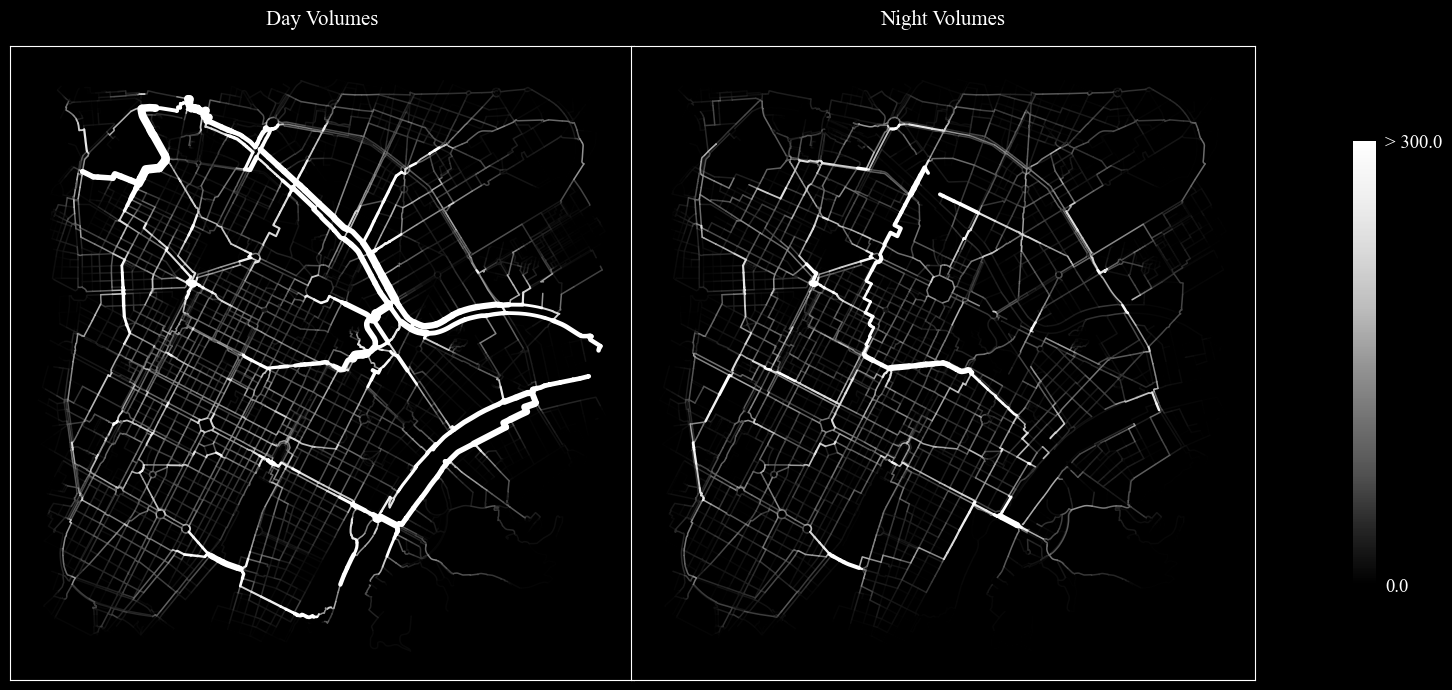

In [28]:
import matplotlib as mpl
# Create a custom colormap from black to yellow
colors = [(0, 0, 0), (1, 1, 0)]  # RGB values for black and yellow
n_bins = 100  # Discretize the colormap into 100 bins

# Create a linear interpolated colormap
yellows = mpl.colors.LinearSegmentedColormap.from_list("black_to_yellow", colors, N=n_bins)


configurations = ['DAY', 'NIGHT']
titles = ['Day Volumes', 'Night Volumes']
norm = mpl.colors.Normalize(vmin = 0.0, vmax = 300)
volumes_tmp = volumes[(volumes.DAY >= 1.0) & (volumes.NIGHT >= 1.0)].copy()
fig = ci.plot_grid_gdf_columns(volumes_tmp, ncols = 2, figsize = (20, 7), columns = configurations, cmap = 'Greys_r', norm = norm,
                               titles = titles, legend = False, cbar = True, cbar_ticks = 1, cbar_max_symbol = True, 
                               cbar_shrink = 0.70, geometry_size_factor = 0.0065, axes_frame = True,  black_background = True)

In [29]:
ax1 = fig.axes[0]
ax2 = fig.axes[1]

In [50]:
rivers.plot(ax=ax1, color='darkblue', zorder=1)
parks.plot(ax=ax2, color='darkgreen', zorder=2)

<Axes: title={'center': 'Night Volumes'}>

In [41]:
parks

,barrier_type,barrierID,geometry


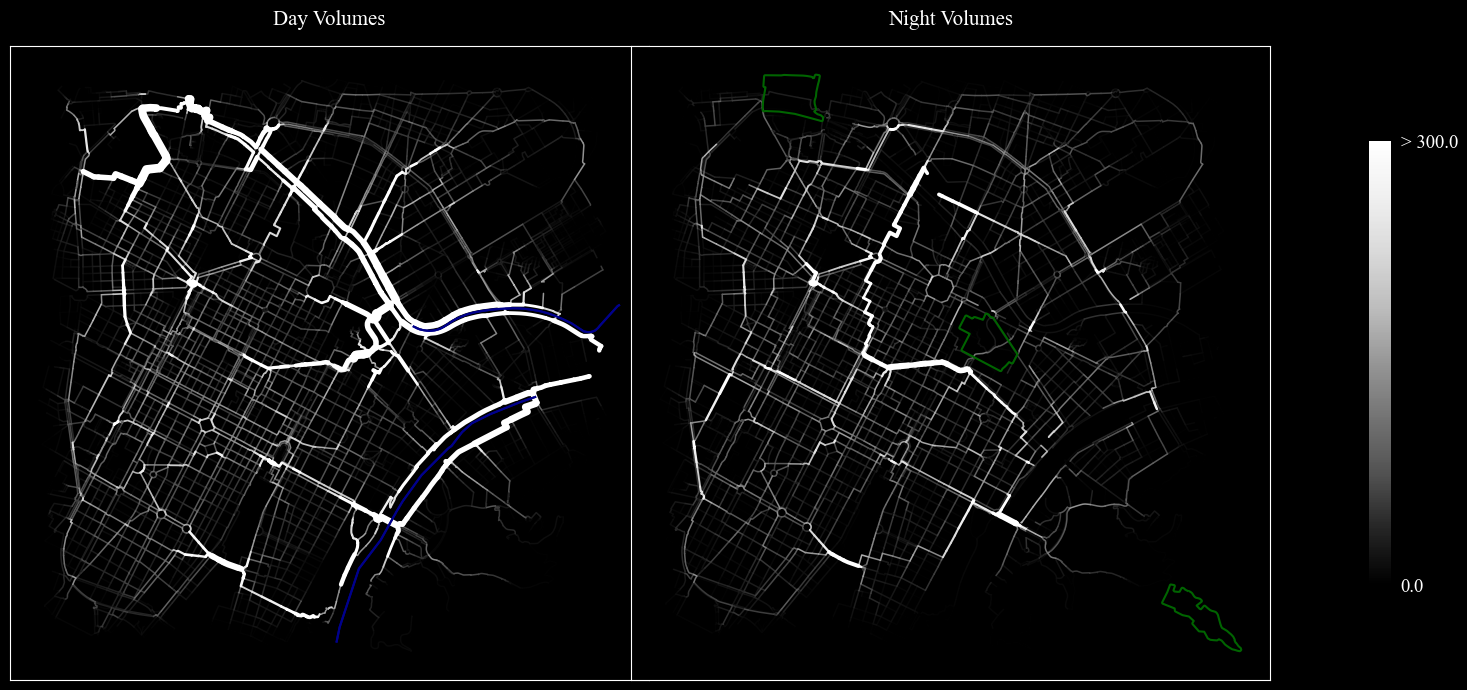

In [51]:
fig.axes[0] = ax1
fig

In [22]:
fig.savefig("f2_volumes.pdf", bbox_inches='tight')

## Differences

In [13]:
edges = edges_gdf.copy()  # street segments GeoDataFrame
edges_list = list(edges['edgeID'])

In [14]:
# Load data for each file

jobs = []
days = []

df_list = []
for df_run in dfs:
    job = int(df_run.iloc[0].job)
    day = int(df_run.iloc[0].day)
    df_run = df_run[['DAY_w', 'NIGHT_w', 'edgeID']].copy()
    # Rename columns dynamically based on job and day
    df_run = df_run.rename(columns={
        "DAY_w": f"DAY_{job}_{day}",
        "NIGHT_w": f"NIGHT_{job}_{day}",
        "edgeID": f"edgeID_{job}_{day}"
    })

    # Append to the DataFrame list
    df_list.append(df_run)
    jobs.append(job)
    days.append(day)

# Combine data from all runs (along columns)
df_runs = pd.concat(df_list, axis=1)

# Use the first column for edgeID (assuming edgeID columns are the same across all jobs and days)
df_runs['edgeID'] = df_runs[f'edgeID_0_1']  # Use edgeID from job=0, day=1
df_runs.head()

,DAY_0_1,NIGHT_0_1,edgeID_0_1,DAY_1_1,NIGHT_1_1,edgeID_1_1,DAY_2_1,NIGHT_2_1,edgeID_2_1,DAY_3_1,...,DAY_1_7,NIGHT_1_7,edgeID_1_7,DAY_2_6,NIGHT_2_6,edgeID_2_6,DAY_2_7,NIGHT_2_7,edgeID_2_7,edgeID
0,0.271,0.752,0,0.463,0.805,0,0.331,0.681,0,0.497,...,0.376,0.520,0,0.449,0.487,0,0.382,0.538,0,0
1,0.157,2.239,1,0.256,3.098,1,0.224,2.674,1,0.488,...,0.224,3.959,1,0.223,3.944,1,0.342,3.907,1,1
2,0.771,2.482,2,0.876,1.940,2,0.744,3.045,2,0.585,...,0.694,2.828,2,0.888,2.024,2,0.631,2.901,2,2
3,2.239,2.459,3,2.368,2.080,3,2.140,2.832,3,2.664,...,2.136,2.557,3,2.982,2.767,3,2.485,2.107,3,3
4,0.586,0.416,4,0.456,0.095,4,0.399,0.080,4,0.660,...,0.407,0.182,4,0.578,0.439,4,0.237,0.177,4,4


In [15]:
# Labels for configurations (day and night)
labels = ['DAY', 'NIGHT']

# Create a list of dataframes. Each dataframe represents a street segment, containing volumes for each run.
df_edges = []
for edge in edges_list:
    df_tmp = pd.DataFrame(columns=['value', 'configuration'])
    
    for job, day in itertools.product(range(range_jobs), range(1, range_days)):
        df_runs_copy = df_runs.copy()
        df_runs_copy.index = df_runs_copy['edgeID']
        row = df_runs_copy.loc[edge]
        values = [row[f"DAY_{job}_{day}"], row[f"NIGHT_{job}_{day}"]]
        for nn, value in enumerate(values):  
            df_tmp.loc[-1] = [value, labels[nn]]
            df_tmp.index = df_tmp.index + 1
            
    df_tmp['value'] = df_tmp['value'].astype(int)
    df_edges.append(df_tmp)

In [16]:
# Initialize columns for p-values and classification in the edges GeoDataFrame
volumes['night_pvalue'] = 0.000
volumes['day_pvalue'] = 0.000
volumes['night_pvalue_cl'] = "No significant diff."
volumes['day_pvalue_cl'] = "No significant diff."

# Perform Wilcoxon test for each edge
for n, df_edge in enumerate(df_edges):
    x = df_edge[df_edge['configuration'] == 'DAY']['value'].to_list()
    y = df_edge[df_edge['configuration'] == 'NIGHT']['value'].to_list()

    # DAY vs NIGHT
    if x != y:
        day_night = pin.wilcoxon(x=x, y=y, alternative='two-sided')
        night_pvalue = day_night.iloc[0]['p-val']
    else:
        night_pvalue = 1.0

    # Assign results to the edges GeoDataFrame
    edge = edges_list[n]
    volumes.at[edge, 'night_pvalue'] = night_pvalue
    
    if volumes.loc[edge]['night_pvalue'] <= 0.05:
        if volumes.loc[edge]['NIGHT'] > volumes.loc[edge]['DAY']:
            color_night = "Significant diff. (+)"
        else:
            color_night = "Significant diff. (-)"
        volumes.at[edge, 'night_pvalue_cl'] = color_night

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


In [17]:
volumes[['edgeID', 'night_pvalue', 'night_pvalue_cl']].head()

,edgeID,night_pvalue,night_pvalue_cl
0,0,3.458e-01,No significant diff.
1,1,4.547e-13,Significant diff. (+)
2,2,4.547e-13,Significant diff. (+)
3,3,6.270e-01,No significant diff.
4,4,1.000e+00,No significant diff.


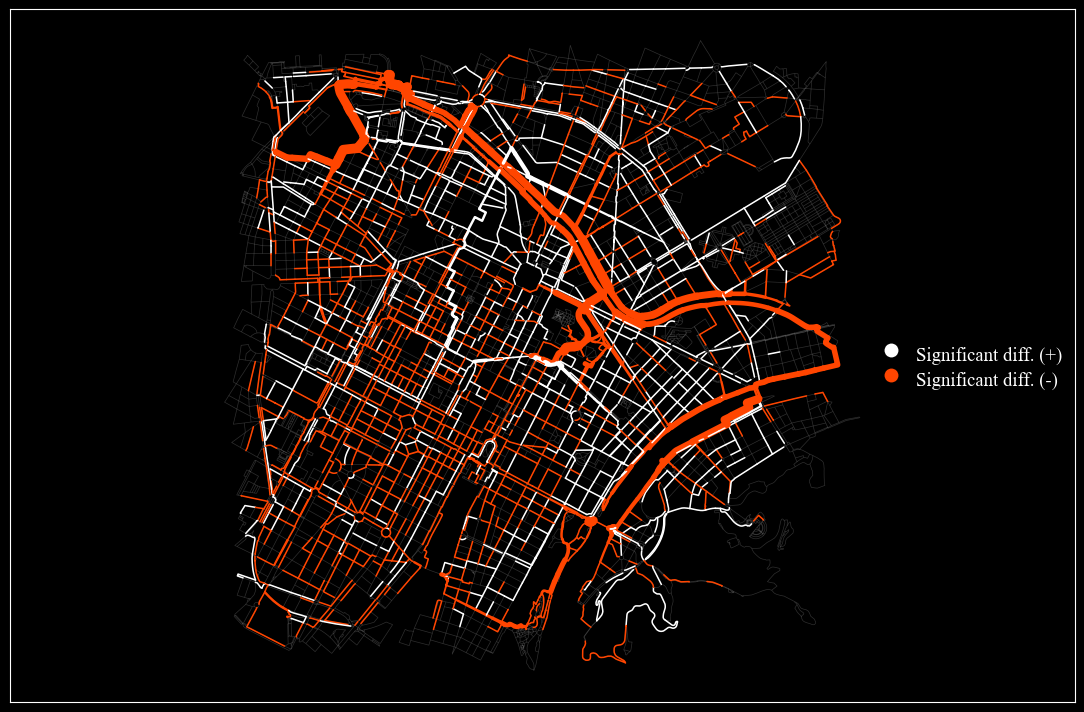

In [23]:
# building the colormap
from matplotlib.colors import LinearSegmentedColormap

black_l = ci.lighten_color('black', 0.55)
blue = ci.lighten_color('white', 1.00)
red = ci.lighten_color('orangered', 1.00)
list_colors = [blue, red]

volumes['diff'] = abs(volumes['NIGHT']- volumes['DAY'])

lw_column = 'diff'
column =  'night_pvalue_cl'

cmap = LinearSegmentedColormap.from_list('custom_cmap', list_colors)
fig = ci.plot_gdf(volumes[volumes[column] != 'No significant diff.'], column = column, classes = 5,
               cmap = cmap, title = '', legend = True, figsize = (12, 8),
                       axes_frame = True, scheme = None, geometry_size_column = lw_column, 
                       geometry_size_factor = 0.008, black_background = True, base_map_gdf = volumes, base_map_zorder = 0, 
                       base_map_color = black_l, base_map_geometry_size = 0.5)

In [24]:
fig.savefig("f3_differences.pdf", bbox_inches='tight')